## 1. Importing Basic Libraries

In [1]:
import numpy as np
import pandas as pd

import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.data import load
from collections import Counter
from sklearn import svm

import string
import re

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Importing ISOT Dataset (.csv)

ISOT_fake = pd.read_csv("./Dataset/Fake.csv")
ISOT_true = pd.read_csv("./Dataset/True.csv")

# Creating labels for each category of fake news

ISOT_fake["label"] = 1
ISOT_true["label"] = 0

# Importing FNN BuzzFeed dataset(.csv)

FNN_fake = pd.read_csv("./Dataset/BuzzFeed_fake_news_content.csv")
FNN_true = pd.read_csv("./Dataset/BuzzFeed_real_news_content.csv")

# Creating labels for each category of fake news

FNN_fake["label"] = 1
FNN_true["label"] = 0

In [3]:
print(ISOT_fake.shape)
print(FNN_fake.shape)

(23481, 5)
(91, 13)


In [4]:
ISOT_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1

In [5]:
FNN_fake.head()

id                                              title  \
0   Fake_1-Webpage  Proof The Mainstream Media Is Manipulating The...   
1  Fake_10-Webpage  Charity: Clinton Foundation Distributed “Water...   
2  Fake_11-Webpage  A Hillary Clinton Administration May be Entire...   
3  Fake_12-Webpage  Trump’s Latest Campaign Promise May Be His Mos...   
4  Fake_13-Webpage                    Website is Down For Maintenance   

                                                text  \
0  I woke up this morning to find a variation of ...   
1  Former President Bill Clinton and his Clinton ...   
2  After collapsing just before trying to step in...   
3  Donald Trump is, well, deplorable. He’s sugges...   
4                    Website is Down For Maintenance   

                                                 url  \
0  http://www.addictinginfo.org/2016/09/19/proof-...   
1  http://eaglerising.com/36899/charity-clinton-f...   
2  http://eaglerising.com/36880/a-hillary-clinton...   
3  http://www.addictinginfo.org/2016/09/19/trumps...   
4  http://www.proudcons.com/clinton-foundation-ca...   

                                             top_img  \
0  http://addictinginfo.addictinginfoent.netdna-c...   
1  http://eaglerising.com/wp-content/uploads/2016...   
2  http://eaglerising.com/wp-content/uploads/2016...   
3  http://addictinginfo.addictinginfoent.netdna-c...   
4                                                NaN   

                       authors                        source  \
0              Wendy Gittleson  http://www.addictinginfo.org   
1               View All Posts        http://eaglerising.com   
2  View All Posts,Tony Elliott        http://eaglerising.com   
3                  John Prager  http://www.addictinginfo.org   
4                          NaN      http://www.proudcons.com   

               publish_date movies  \
0  {'$date': 1474243200000}    NaN   
1  {'$date': 1474416521000}    NaN   
2  {'$date': 1474416638000}    NaN   
3  {'$date': 1474243200000}    NaN   
4                       NaN    NaN   

                                              images  \
0  http://i.imgur.com/JeqZLhj.png,http://addictin...   
1  http://constitution.com/wp-content/uploads/201...   
2  http://constitution.com/wp-content/uploads/201...   
3  http://i.imgur.com/JeqZLhj.png,http://2.gravat...   
4                                                NaN   

                                      canonical_link  \
0  http://addictinginfo.com/2016/09/19/proof-the-...   
1  http://eaglerising.com/36899/charity-clinton-f...   
2  http://eaglerising.com/36880/a-hillary-clinton...   
3  http://addictinginfo.com/2016/09/19/trumps-lat...   
4                                                NaN   

                                           meta_data  label  
0  {"publisher": "Addicting Info | The Knowledge ...      1  
1  {"description": "The possibility that CHAI dis...      1  
2  {"description": "Hillary Clinton may be the fi...      1  
3  {"publisher": "Addicting Info | The Knowledge ...      1  
4  {"og": {"url": "http://www.proudcons.com", "ty...      1

### Combining both datasets into one (ISOT)

In [10]:
ISOT_df = pd.concat([ISOT_fake, ISOT_true])

# Remove irrelevant columns
ISOT_df.drop(['title', 'date'], axis=1, inplace=True)

# Removing rows with empty text

ISOT_df['text'].dropna(inplace = True)
ISOT_df.head()

text subject  label
0  Donald Trump just couldn t wish all Americans ...    News      1
1  House Intelligence Committee Chairman Devin Nu...    News      1
2  On Friday, it was revealed that former Milwauk...    News      1
3  On Christmas day, Donald Trump announced that ...    News      1
4  Pope Francis used his annual Christmas Day mes...    News      1

In [4]:
'''
Merged dataset with counts of labelled news where:
1 = fake news 
0 = true news

Total n of elements = 44,898
'''

ISOT_df.label.value_counts(dropna = False)

1    23481
0    21417
Name: label, dtype: int64

In [5]:
# Shuffle dataframe
from sklearn.utils import shuffle
ISOT_df = shuffle(ISOT_df)
ISOT_df = ISOT_df.reset_index(drop=True)

ISOT_df.head()

text       subject  label
0  NEW YORK (Reuters) - President Donald Trump sa...  politicsNews      0
1  Republicans found their new election year wedg...          News      1
2  One of the many reasons Americans were suspici...          News      1
3  DHAKA/KUTUPALONG, Bangladesh (Reuters) - How d...     worldnews      0
4  Did Bruce Ohr get cold feet?  Demoted Deputy A...      politics      1

### Combining both datasets into one (FNN)

In [7]:
FNN_df = pd.concat([FNN_fake, FNN_true])

# Remove irrelevant columns
FNN_df.drop(['id','title','top_img','url','authors','publish_date','movies','images','canonical_link','meta_data'], axis=1, inplace=True)

# Removing rows with empty text

FNN_df['text'].dropna(inplace = True)

In [7]:
FNN_df.label.value_counts(dropna = False)

1    91
0    91
Name: label, dtype: int64

In [8]:
FNN_df = shuffle(FNN_df)
FNN_df = FNN_df.reset_index(drop=True)

FNN_df.head()

text  \
0  Kellyanne Conway praised Donald Trump for show...   
1  Donna Brazile said Trump’s hectoring of Americ...   
2                    Website is Down For Maintenance   
3  \n\nPosted by Frank Wilkenmeyer on 25 Sep 2016...   
4  Milwaukee Sheriff David A. Clarke Jr. has been...   

                         source  label  
0              http://politi.co      0  
1              http://politi.co      0  
2      http://www.proudcons.com      1  
3   http://winningdemocrats.com      1  
4  http://www.addictinginfo.org      0

## 2. Exploratory Dataset Analysis (EDA)

### 2.1 ISOT Dataset

First the true news dataset will be briefly explored followed by the fake news datset

In [9]:
ISOT_df_sub=ISOT_df.groupby(['subject', 'label'])['text'].count()
ISOT_df_sub

subject          label
Government News  1         1570
Middle-east      1          778
News             1         9050
US_News          1          783
left-news        1         4459
politics         1         6841
politicsNews     0        11272
worldnews        0        10145
Name: text, dtype: int64

In [10]:
ISOT_df_sub = ISOT_df_sub.unstack().fillna(0)
ISOT_df_sub

label                  0       1
subject                         
Government News      0.0  1570.0
Middle-east          0.0   778.0
News                 0.0  9050.0
US_News              0.0   783.0
left-news            0.0  4459.0
politics             0.0  6841.0
politicsNews     11272.0     0.0
worldnews        10145.0     0.0

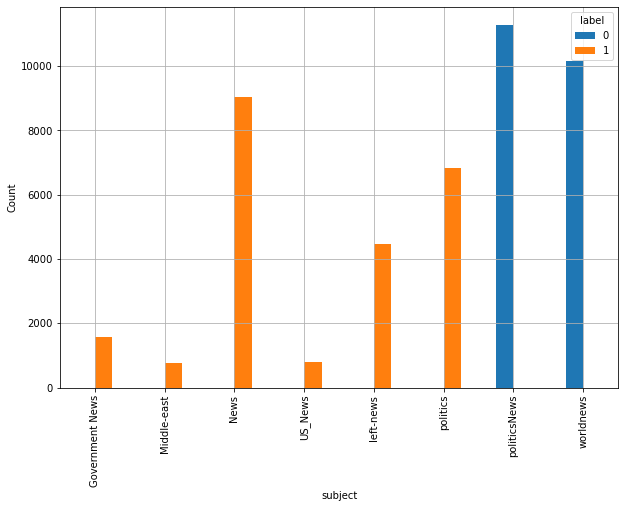

In [11]:
# Bar graph visualisation
sub_bargraph = (ISOT_df_sub).plot(kind='bar',figsize=(10, 7),grid=True)
sub_bargraph.set_ylabel('Count')
plt.show()

It can be seen that the true news (0) is equally distributed whereas fake news(1) is not equally distributed 
with true news being from the categories of 
* PoliticsNews
* WorldNews

### 2.1.1 Analyzing Ngrams

In [119]:
def clean_ngrams(text):
    
    stopwords = nltk.corpus.stopwords.words('english')
    wnl = nltk.stem.WordNetLemmatizer()
    
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [120]:
ISOT_df_ngram = clean_ngrams(''.join(str(ISOT_df['text'].tolist())))

In [126]:
ISOT_bigrams_series = (pd.Series(nltk.ngrams(ISOT_df_ngram, 2)).value_counts())[:20]
ISOT_trigrams_series  = (pd.Series(nltk.ngrams(ISOT_df_ngram, 3)).value_counts())[:20]

Text(0.5, 0, 'Count')

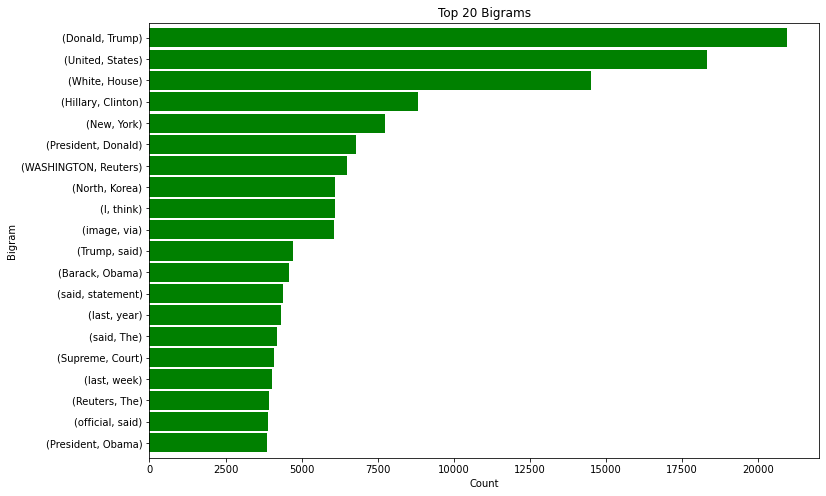

In [137]:
ISOT_bigrams_series.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('Top 20 Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

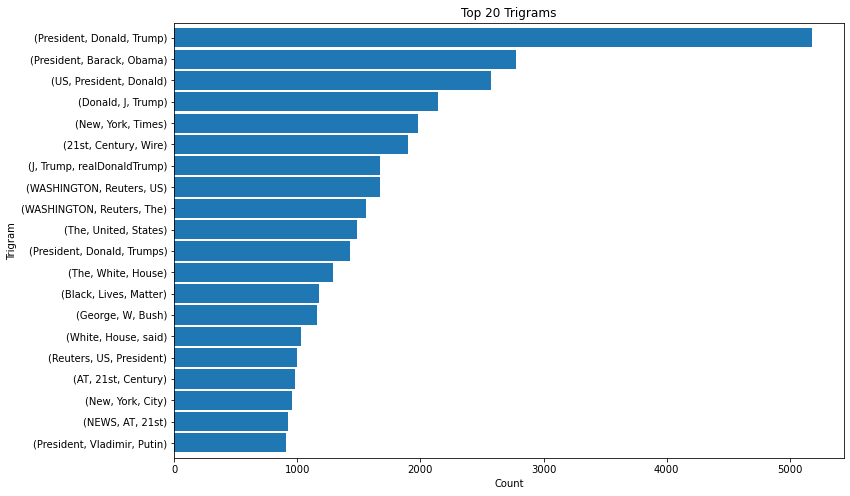

In [136]:
ISOT_trigrams_series.sort_values().plot.barh(width=.9, figsize=(12, 8))
plt.title('Top 20 Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Count')

### 2.1.2 Generating Word Clouds

In [12]:
from wordcloud import WordCloud

def gen_wordcloud(dataframe):
    text = ''
    for news in dataframe.text.values:
        text += f" {news}"
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
    fig = plt.figure(
        figsize = (40,30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    del text

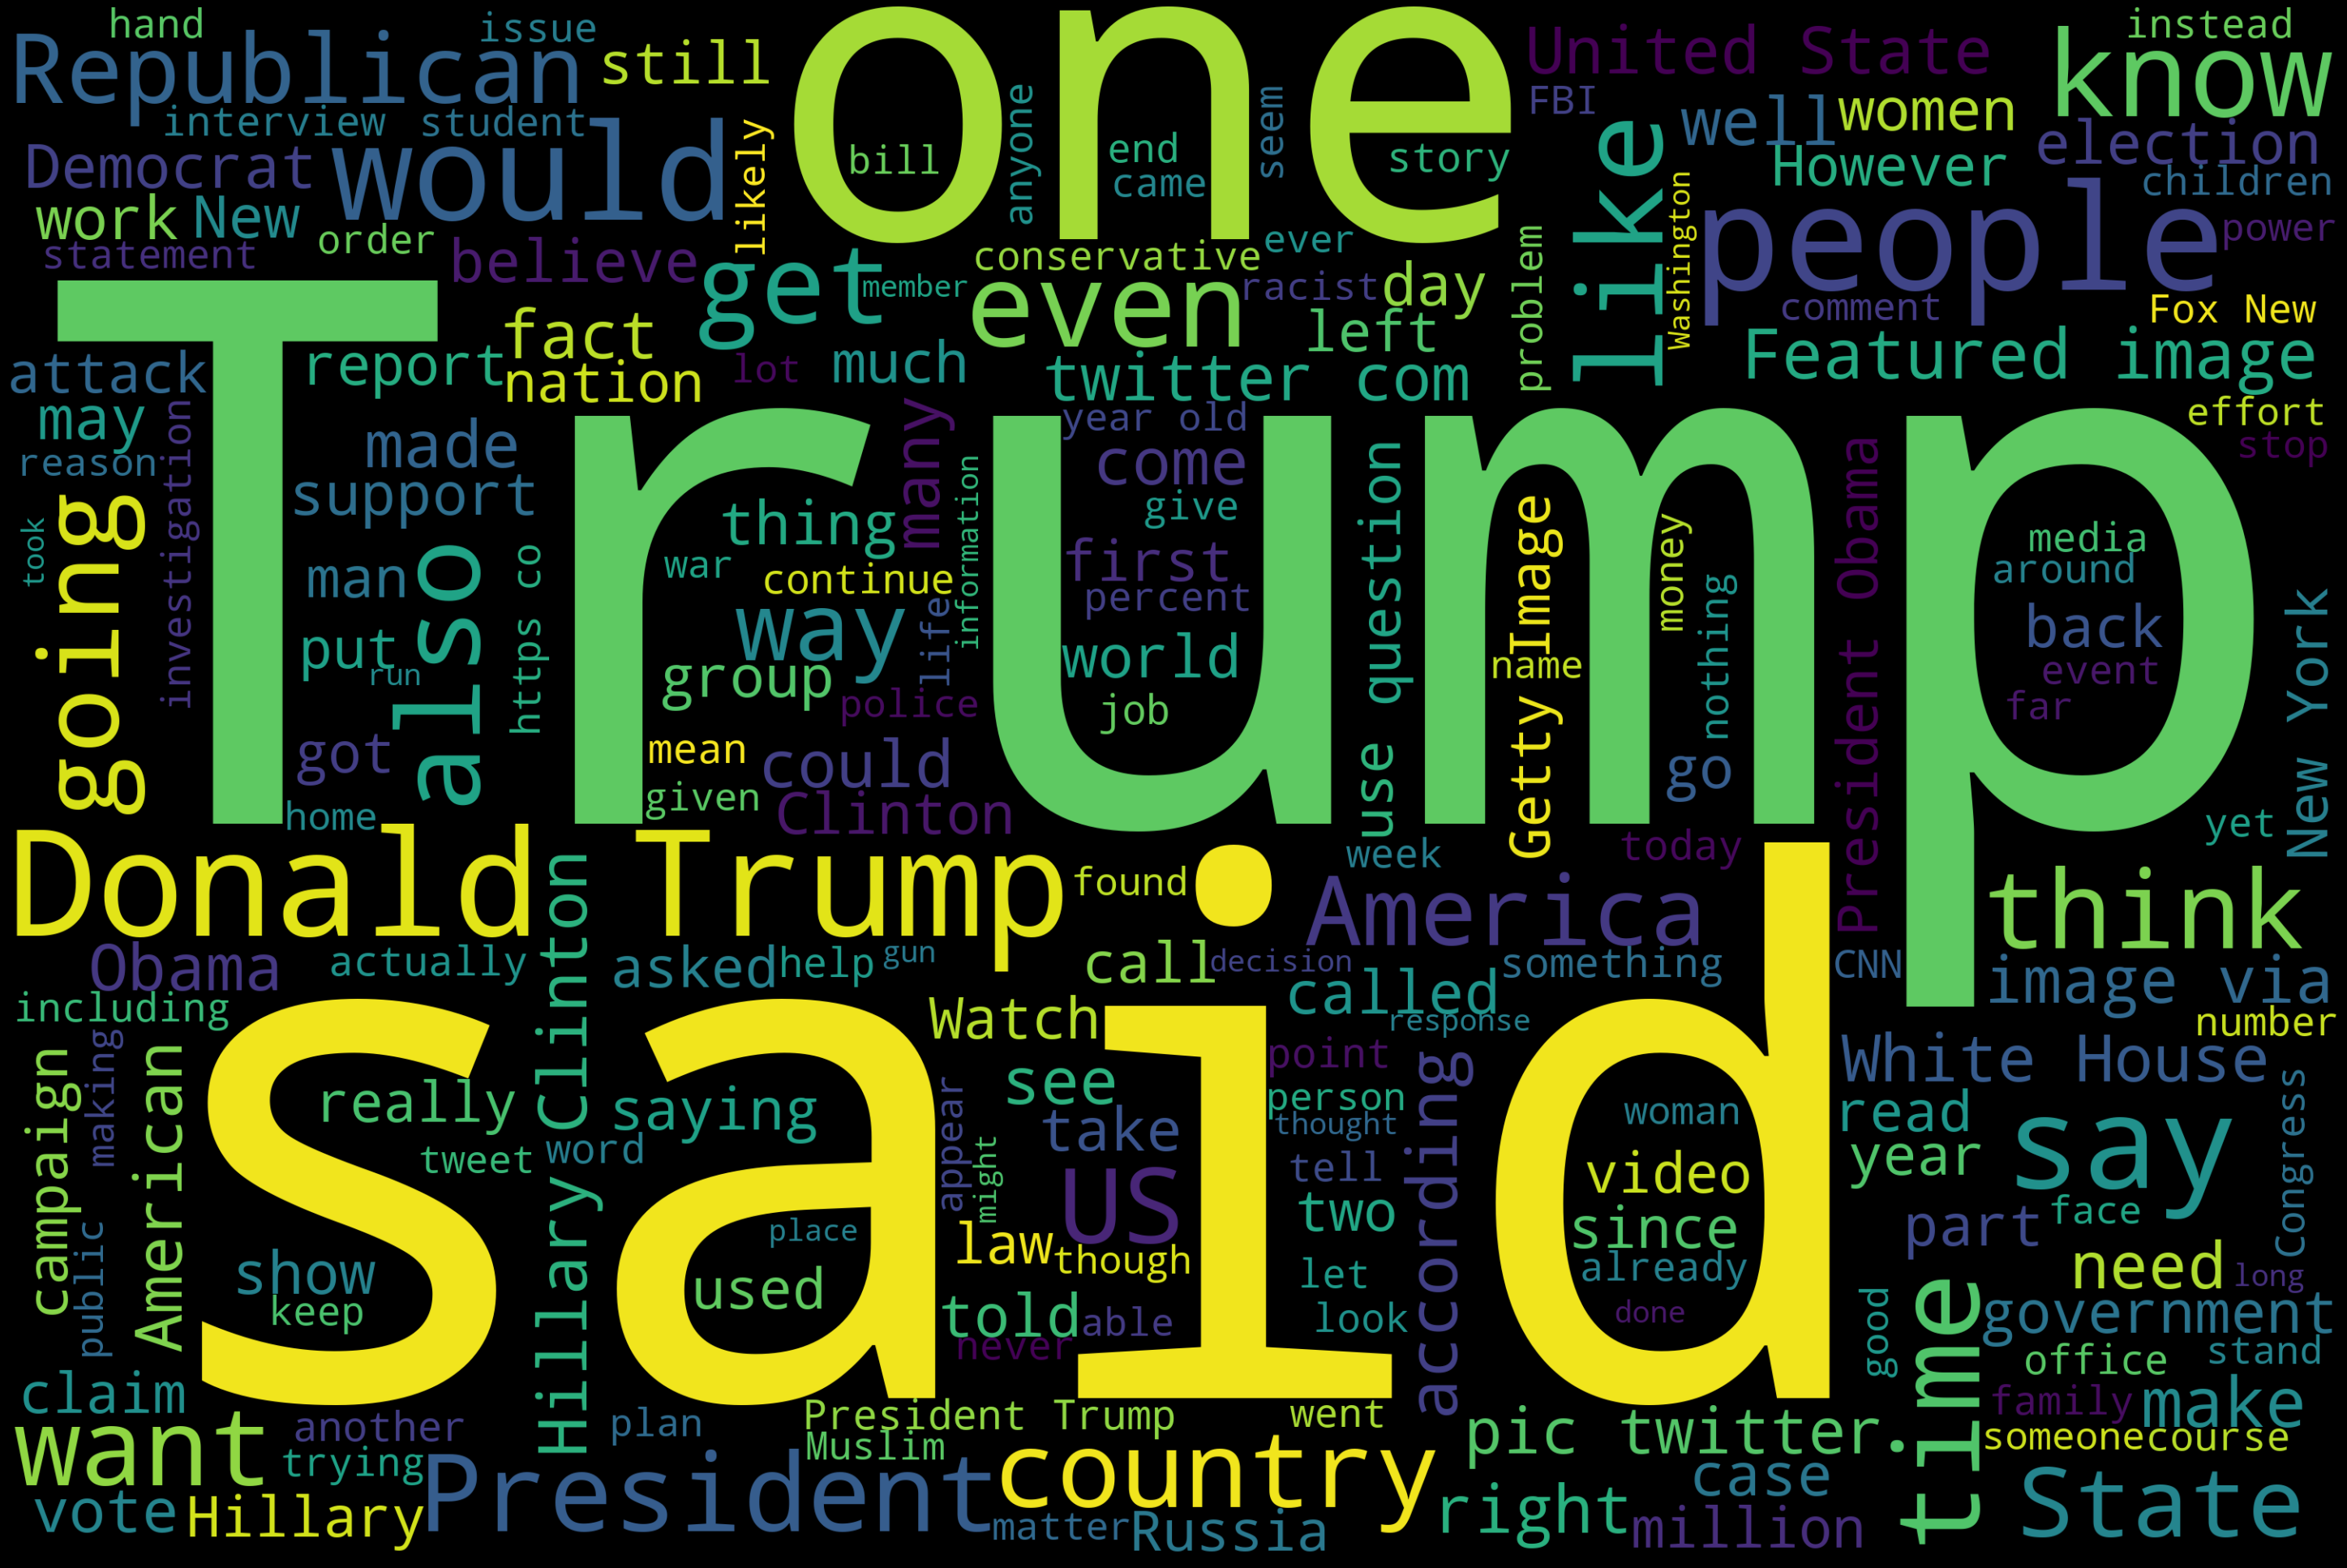

Wall time: 2min 11s


In [13]:
%%time
gen_wordcloud(ISOT_fake)

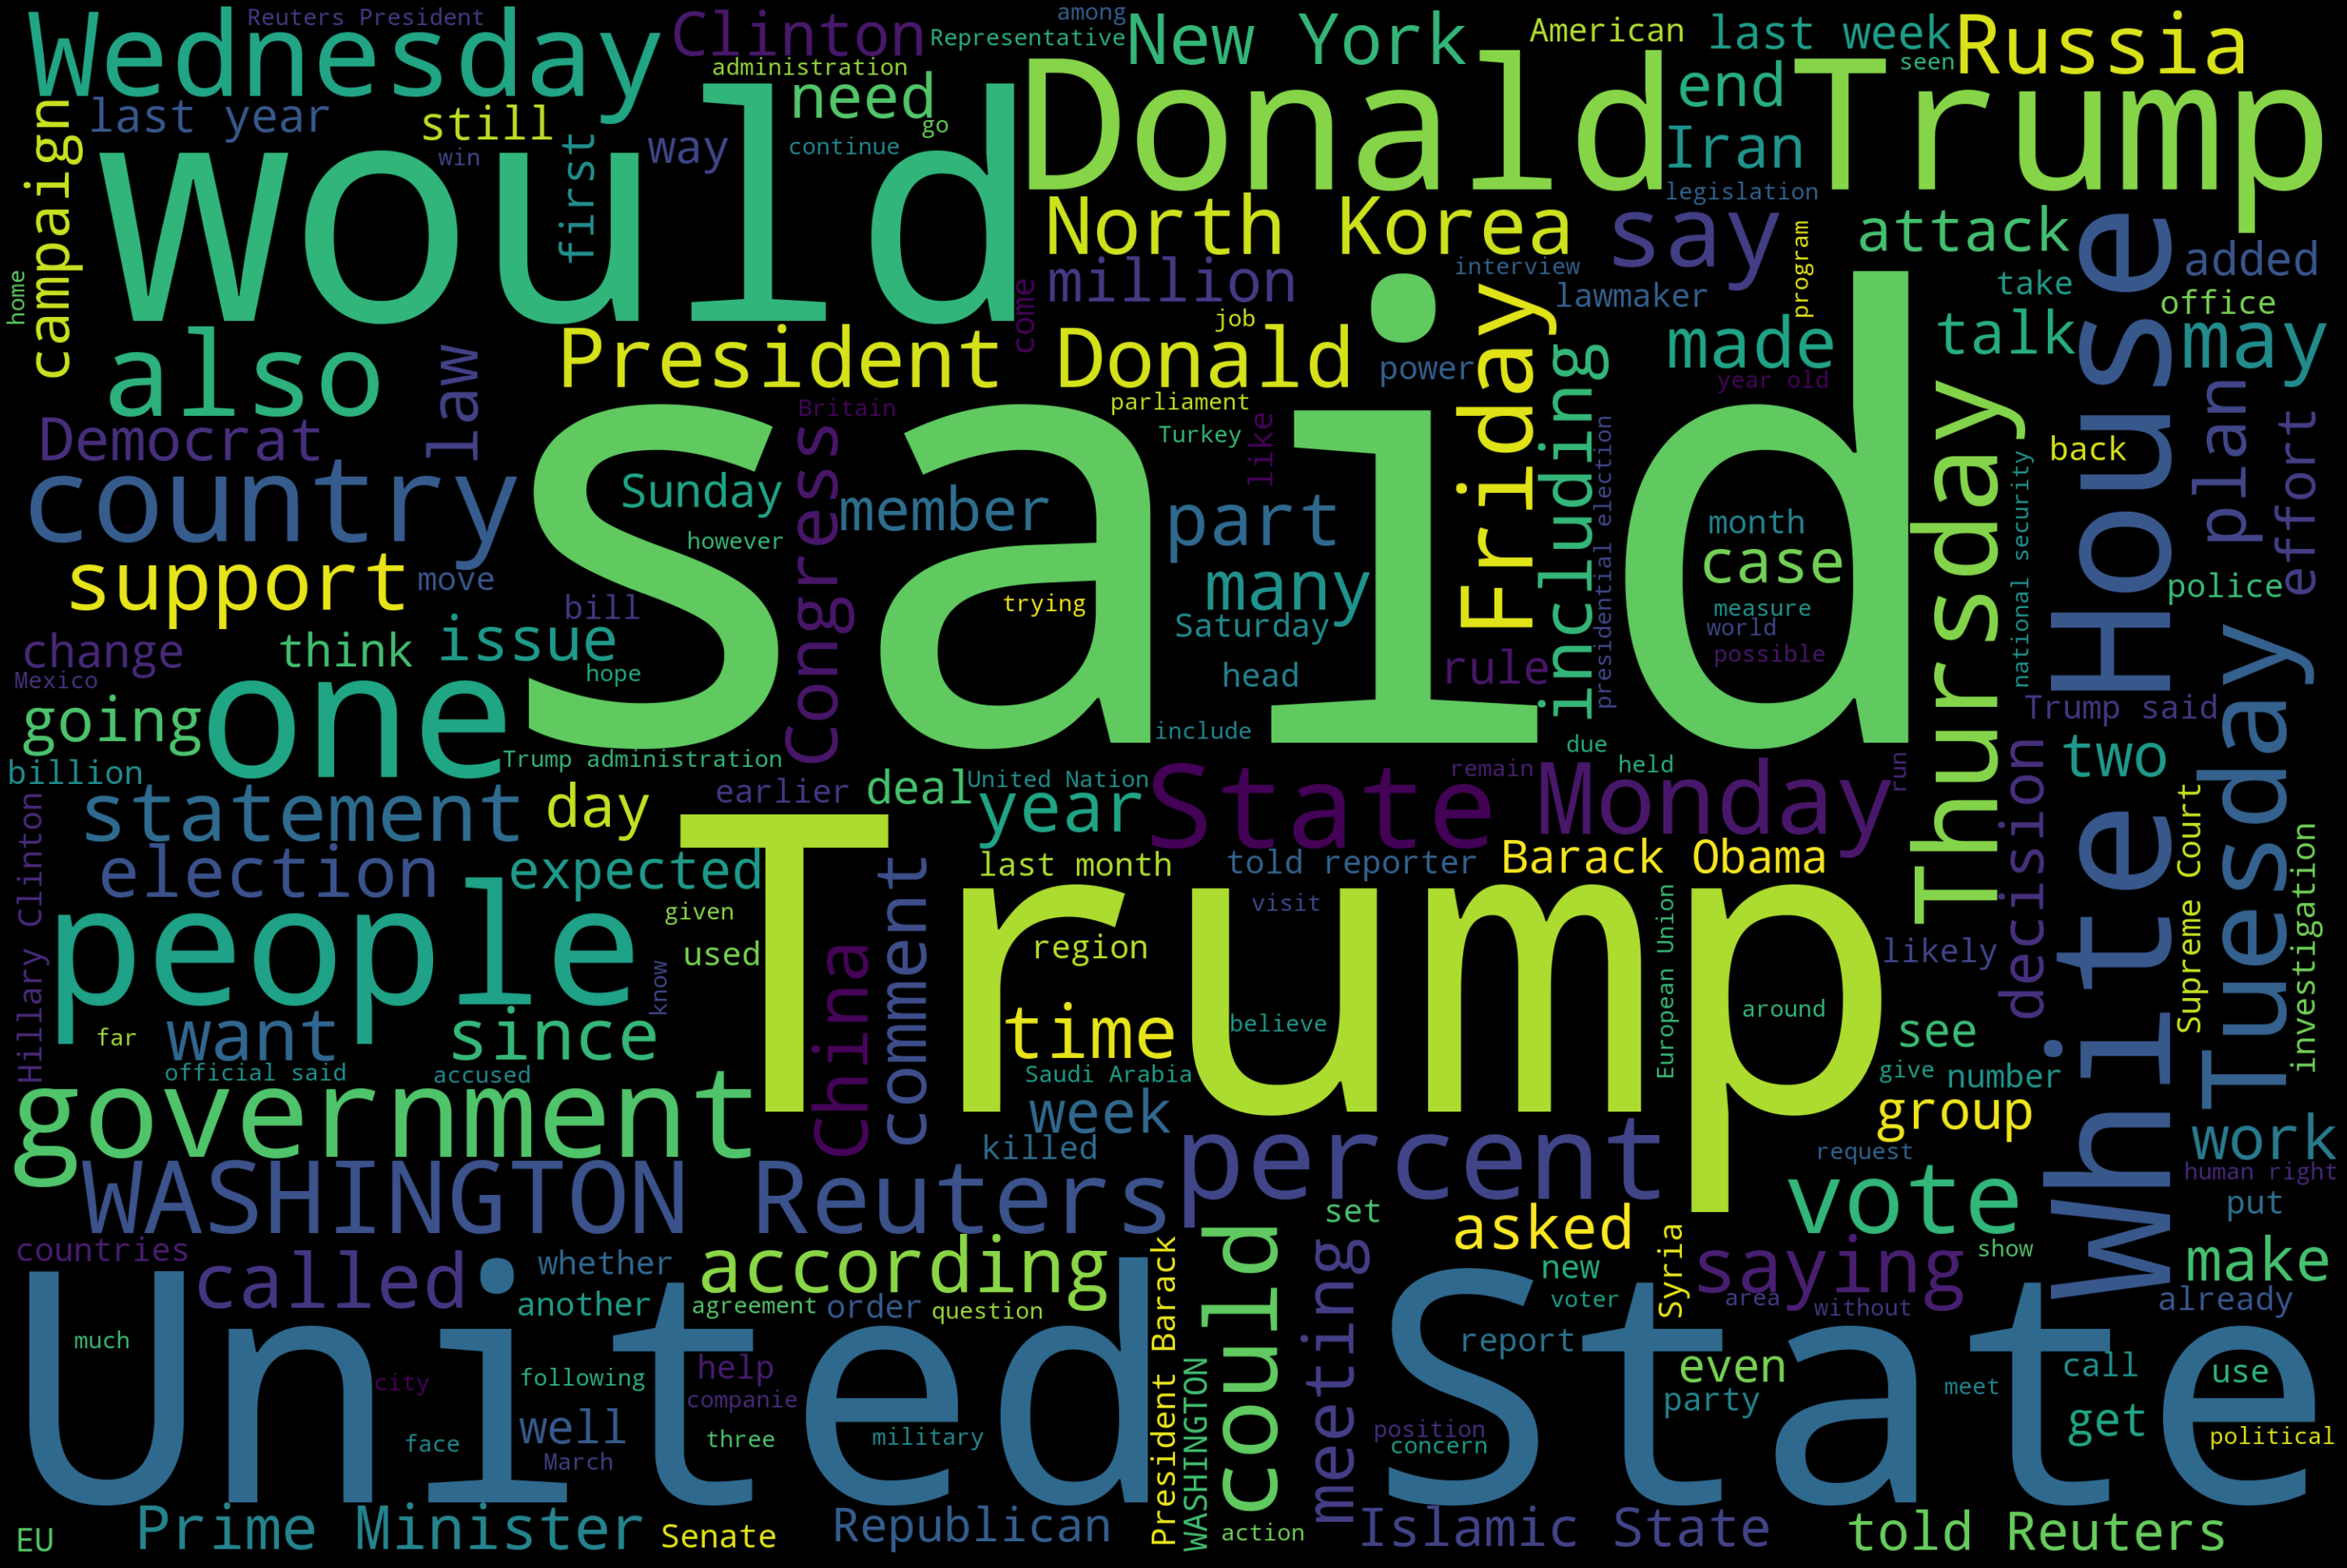

Wall time: 4min 39s


In [14]:
%%time 
gen_wordcloud(ISOT_true)

### 2.2 FNN Dataset

### 2.2.1 Analyzing News Sources

In [12]:
FNN_df.head()

text  \
0  Kellyanne Conway praised Donald Trump for show...   
1  Donna Brazile said Trump’s hectoring of Americ...   
2                    Website is Down For Maintenance   
3  \n\nPosted by Frank Wilkenmeyer on 25 Sep 2016...   
4  Milwaukee Sheriff David A. Clarke Jr. has been...   

                         source  label  
0              http://politi.co      0  
1              http://politi.co      0  
2      http://www.proudcons.com      1  
3   http://winningdemocrats.com      1  
4  http://www.addictinginfo.org      0

In [13]:
fake_order=FNN_fake['source'].value_counts().sort_values(ascending=False).index

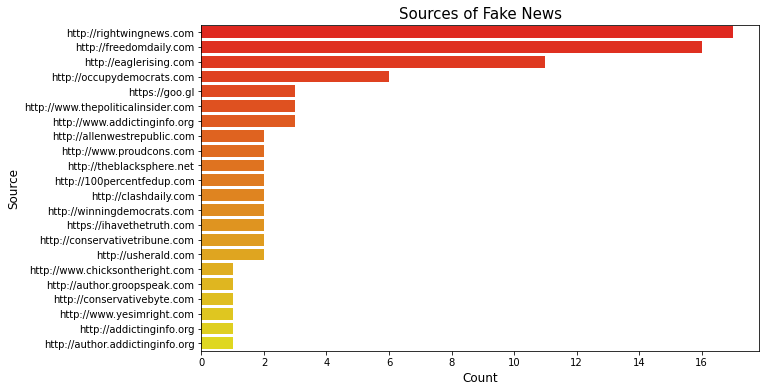

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(y='source', data=FNN_fake,order = fake_order,palette='autumn')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Fake News',fontsize=15)
plt.show()

In [18]:
true_order=FNN_true['source'].value_counts().sort_values(ascending=False).index

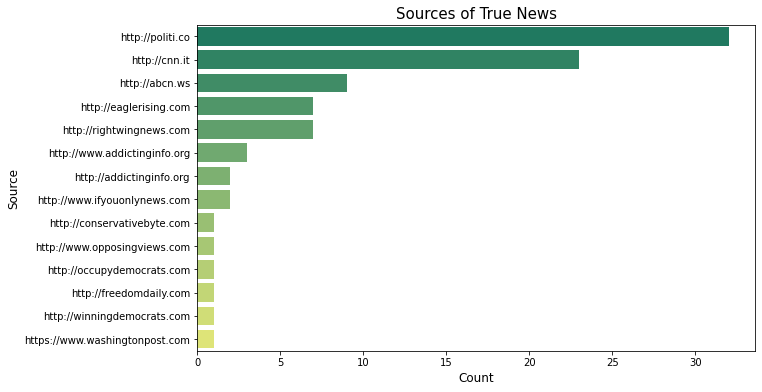

In [19]:
plt.figure(figsize=(10,6))
sns.countplot(y='source', data=FNN_true,order = true_order,palette='summer')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of True News',fontsize=15)
plt.show()

### 2.2.2 Generating Word Clouds

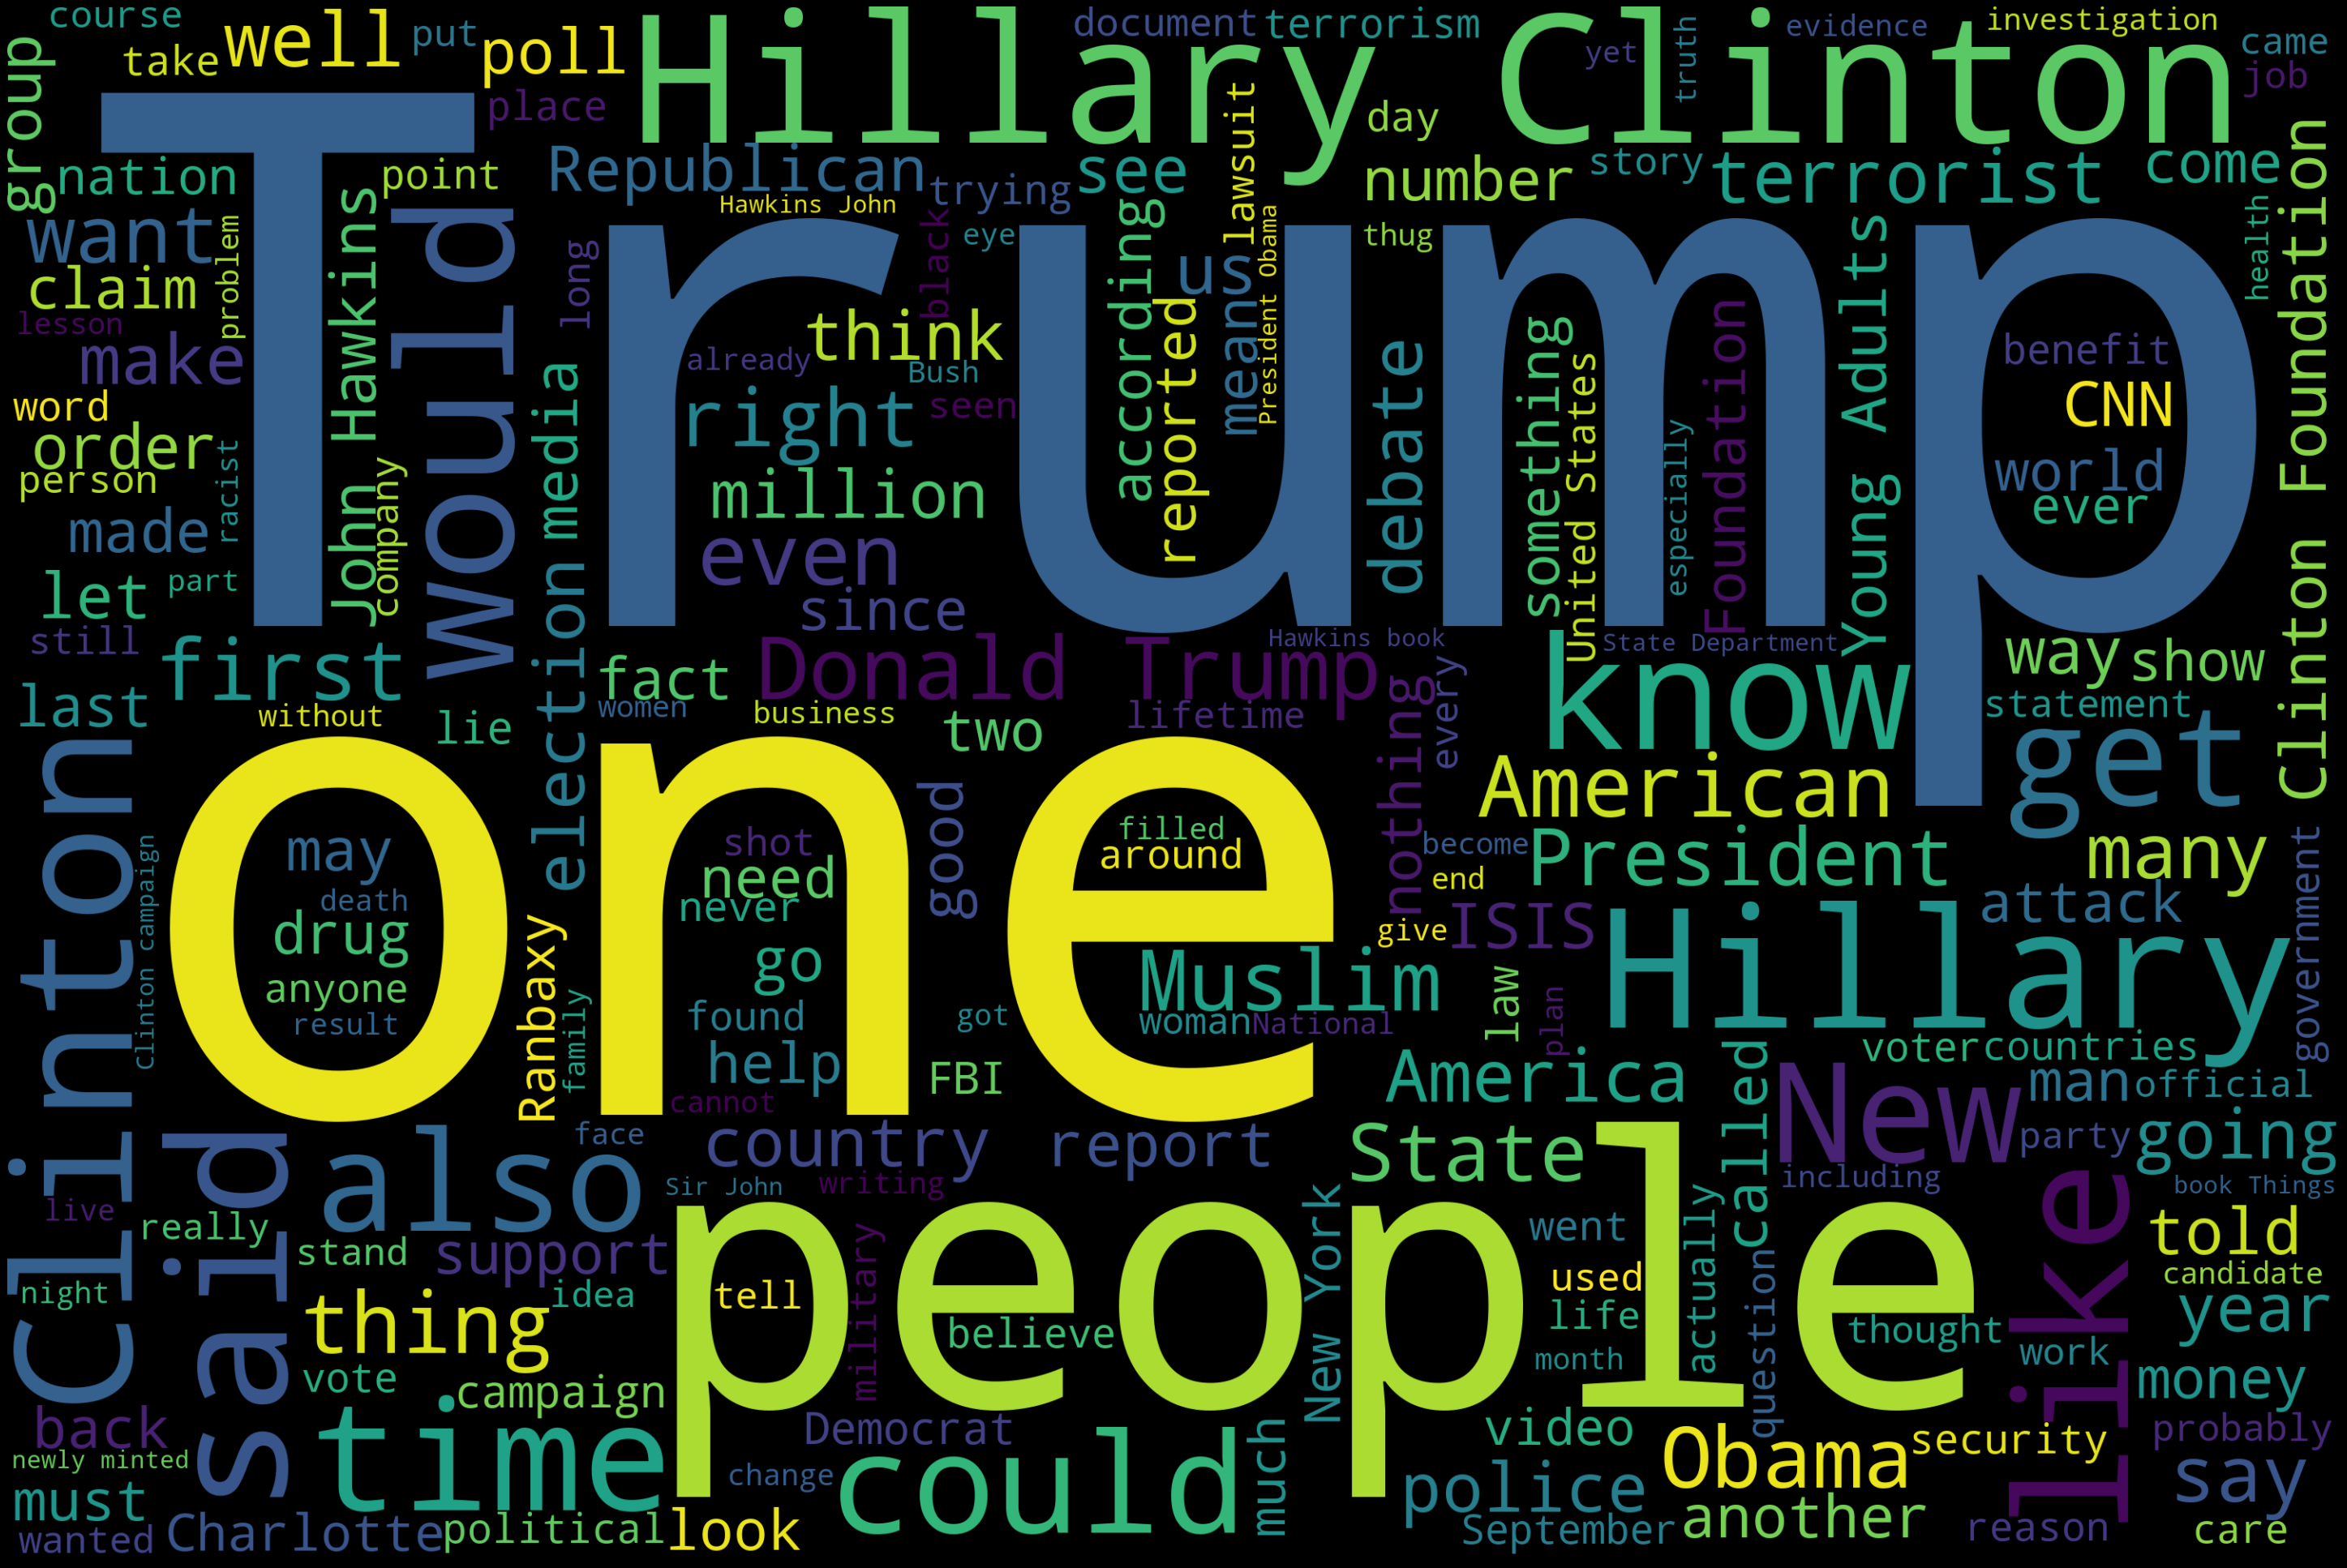

In [23]:
gen_wordcloud(FNN_fake)

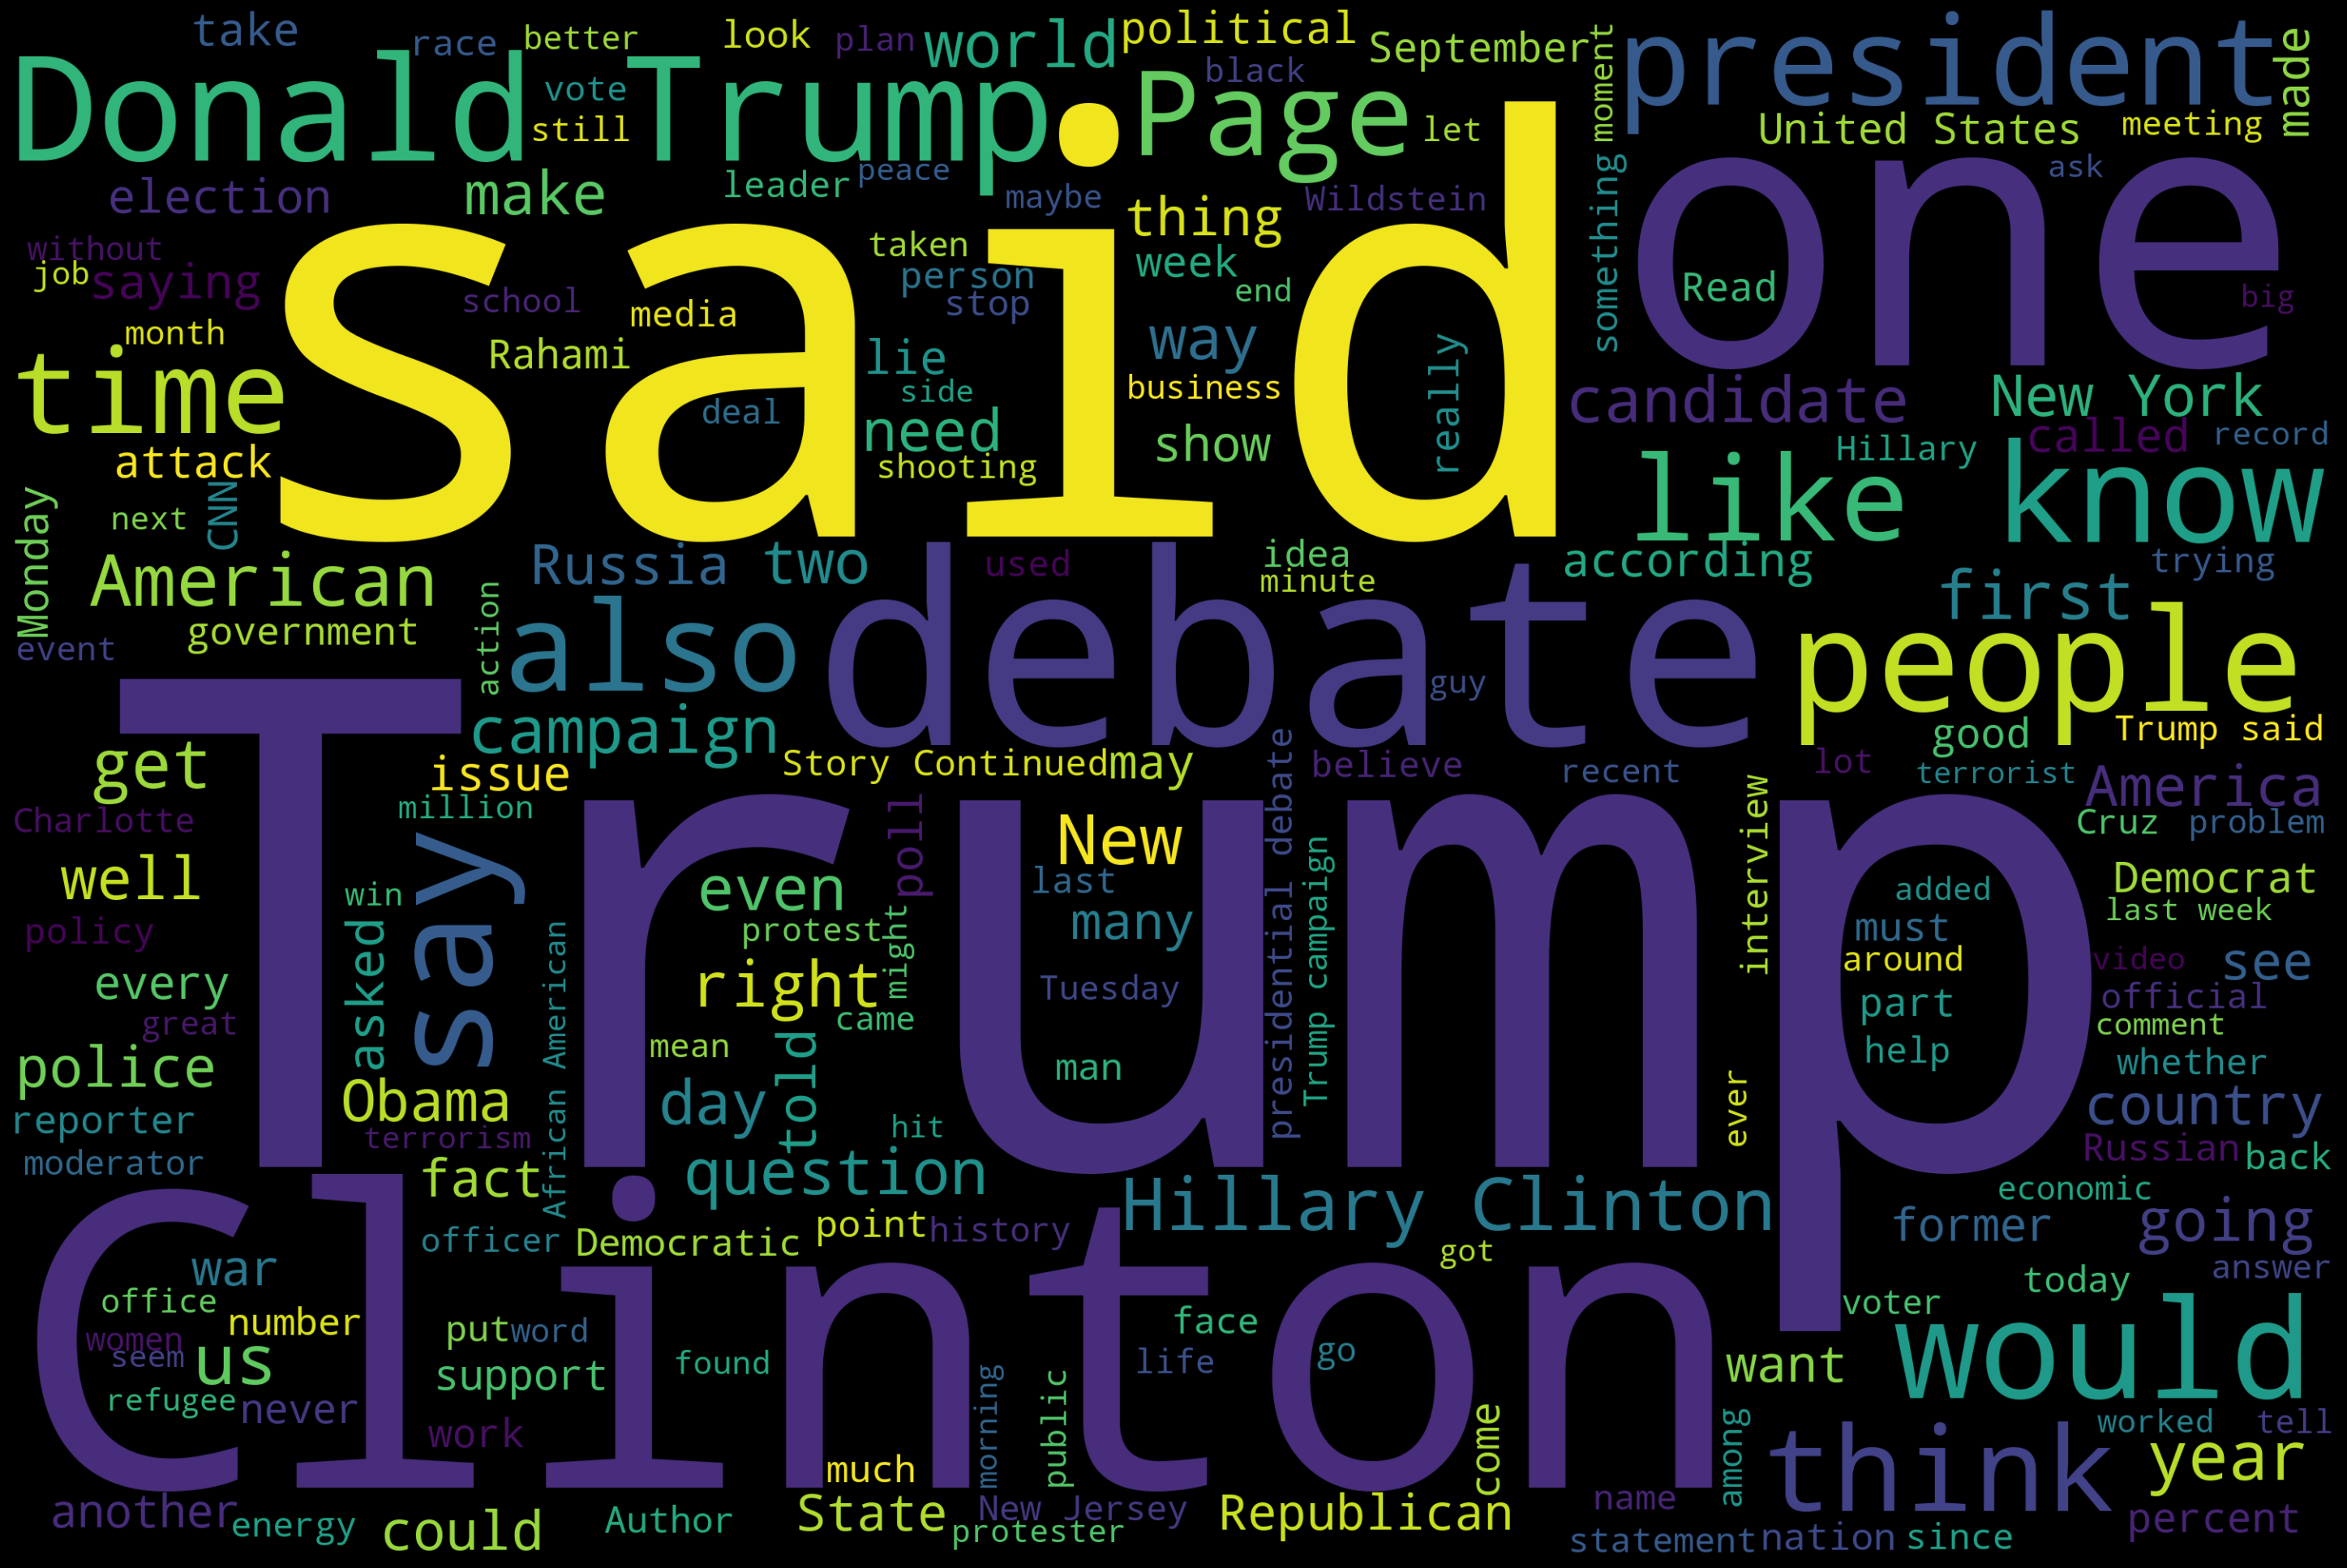

In [24]:
gen_wordcloud(FNN_true)

## 3. Dataset Preprocessing

In [25]:

'''

Preprocessing steps include: 
1. Removing punctuation
2. Converting to lowercase
3. Removing stopwords
4. Tokenization
5. Lemmatizing word tokens

'''

def process_text (text):
    
    stopwords = set(nltk.corpus.stopwords.words('english'))
    lemm = WordNetLemmatizer()

    # Removing Punctuationm
    process_text = "".join ([char for char in text if char not in string.punctuation])
    # Tokenizing Text and converting to lowercase
    process_text = re.split('\W+', text.lower())
    # Removing stopwords
    process_text = [word for word in process_text if word not in stopwords]
    # Lemmatization
    process_text = " ".join ([lemm.lemmatize(i,'v') for i in process_text])
    return process_text

def tokenize_text(text):
    
    stopwords = set(nltk.corpus.stopwords.words('english'))
    lemm = WordNetLemmatizer()
    
    # Removing Punctuationm
    tokenize_text = "".join ([char for char in text if char not in string.punctuation])
    # Tokenizing Text and converting to lowercase
    tokenize_text = re.split('\W+', text.lower())
    # Removing stopwords
    #tokenize_text = [word for word in tokenize_text if word not in stopwords]
    join_stopword = (" ".join(tokenize_text))
    return join_stopword

In [26]:
ISOT_df['cleaned'] = ISOT_df['text'].apply(lambda x: process_text(x))
ISOT_df['tokenized'] = ISOT_df['text'].apply(lambda x: tokenize_text(x))

# Rearranging columns
column_names = ["text","tokenized","cleaned","label"]
ISOT_df = ISOT_df.reindex(columns=column_names)

ISOT_df.head()

text  \
0  Watch:You want a #JobsReport?Here's a jobs rep...   
1  On Monday, President Obama announced that he w...   
2  WASHINGTON (Reuters) - White House hopefuls Te...   
3  WASHINGTON (Reuters) - U.S. House Speaker Paul...   
4  Making a political endorsement by the NAACP co...   

                                           tokenized  \
0  watch you want a jobsreport here s a jobs repo...   
1  on monday president obama announced that he wa...   
2  washington reuters white house hopefuls ted cr...   
3  washington reuters u s house speaker paul ryan...   
4  making a political endorsement by the naacp co...   

                                             cleaned  label  
0  watch want jobsreport job report president tru...      1  
1  monday president obama announce expand backgro...      1  
2  washington reuters white house hopefuls ted cr...      0  
3  washington reuters u house speaker paul ryan t...      0  
4  make political endorsement naacp completely ir...      1

In [27]:
FNN_df['cleaned']= FNN_df['text'].apply (lambda x: process_text(x))

# Rearranging columns
column_names =  ['text','cleaned','url','label']
FNN_df = FNN_df.reindex(columns=column_names)

FNN_df.head()

text  \
0  7k SHARES SHARE THIS STORY\n\nLast night, the ...   
1  Note In Arabic Found With NYC Bomb… Call Says ...   
2  The Democrats are using an intimidation tactic...   
3  8.1k SHARES Facebook Twitter\n\nWhat a sign of...   
4  Story highlights Ryan called for calm in Charl...   

                                             cleaned  url  label  
0  7k share share story last night city charlotte...  NaN      1  
1  note arabic find nyc bomb call say bomb police...  NaN      1  
2  democrats use intimidation tactic prone use in...  NaN      1  
3  8 1k share facebook twitter sign time terroris...  NaN      1  
4  story highlight ryan call calm charlotte would...  NaN      0

## 4. Split Test/Train data

In [28]:
# The ISOT dataset shall then be split into train/test data using sklearn 
# Manipulated variable = 'cleaned' column
# Responsiding variable = 'label' ccolumn

from sklearn.model_selection import train_test_split

x = ISOT_df.cleaned 
y = ISOT_df.label

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(35918,) (8980,) (35918,) (8980,)


## 5. Feature Generation


### 5.1 TF_IDF

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vect = CountVectorizer()
x_trainCounts = vect.fit_transform(x_train)

In [30]:
tfidf_transformer = TfidfTransformer()
x_trainTFIDF = tfidf_transformer.fit_transform(x_trainCounts)
x_trainTFIDF.shape

(35918, 99740)

### 5.2 POS Tags

* Example of tags are listed below: (From the NLTK Universal tagset)



| Tag | Meaning | English Examples |
| ------------- |:----------------:|:----------------:|
| ADJ | adjective | new, good, high, special, big, local |
| ADP | adposition  | on, of, at, with, by, into, under |
| ADV  | adverb | really, already, still, early, now |
| CONJ  | conjunction |  and, or, but, if, while, although  |
|  DET | determiner, article  | the, a, some, most, every, no, which  |
| NOUN | noun | noun year, home, costs, time, Africa   |
| NUM |numeral | twenty-four, fourth, 1991, 14:24  |
| PRT  |particle  |  at, on, out, over per, that, up, with   |
| PRON | pronoun |   he, their, her, its, my, I, us  |
| VERB | verb |  is, say, told, given, playing, would  |
| "." | punctuation | " . , ; !"  |
|X | other  | ersatz, esprit, dunno, gr8, univeristy  |


In [31]:
def pos_tag(text):
    postag = nltk.pos_tag(word_tokenize(text),tagset = 'universal')
    pos_list = list()
    for word in postag:
        pos_list.append(word[0] + "/" + word[1])
    
    final = ' '.join(pos_list)
    return final


In [32]:
x_trainPOS = x_train.apply(pos_tag)

In [33]:
print(x_trainPOS.head())

36335    may/VERB time/NOUN many/ADJ years/NOUN ago/ADV...
12384    donald/ADJ trump/NOUN slat/ADJ visit/NOUN grea...
24419    outgo/ADJ army/NOUN chief/ADJ staff/NOUN gen/N...
24740    washington/NOUN reuters/NOUN president/NOUN do...
27039    washington/NOUN reuters/NOUN republicans/VERB ...
Name: cleaned, dtype: object


### 5.3 POS CountVec & TFIDF

In [34]:
vect = CountVectorizer()
x_trainPOS_Count = vect.fit_transform(x_trainPOS)
#x_testPOS_Count = vect.transform(x_testPOS)

In [35]:
tfidf_transformer = TfidfTransformer()
x_trainPOS_Tfidf = tfidf_transformer.fit_transform(x_trainPOS_Count)
#x_testPOS_Tfidf = tfidf_transformer.transform(x_testPOS_Count)
x_trainPOS_Tfidf.shape

(35918, 99743)

### 5.4 N-Grams

Fitting on the training set and transforming on the training and test set assures that:
 - given a word, the word is correctly always mapped on the same column, both in the training and test set. 

In [36]:
vect = CountVectorizer(ngram_range=(2,3))
x_trainNgram = vect.fit_transform(x_train)
vect.get_feature_names()

['00 00',
 '00 00 pm',
 '00 000',
 '00 000 people',
 '00 00pm',
 '00 00pm learn',
 '00 0109',
 '00 0109 est',
 '00 0500',
 '00 0500 gmt',
 '00 0700',
 '00 0700 gmt',
 '00 0800',
 '00 0800 gmt',
 '00 09',
 '00 09 subject',
 '00 11',
 '00 11 march',
 '00 12',
 '00 12 compatriot',
 '00 1200',
 '00 1200 gmt',
 '00 16',
 '00 16 00',
 '00 1600',
 '00 1600 gmt',
 '00 1700',
 '00 1700 gmt',
 '00 18',
 '00 18 00',
 '00 1800',
 '00 1800 gmt',
 '00 1931',
 '00 1931 est',
 '00 201',
 '00 201 000',
 '00 40',
 '00 40 gmt',
 '00 add',
 '00 add trump',
 '00 address',
 '00 address real',
 '00 afternoon',
 '00 afternoon saturday',
 '00 allow',
 '00 allow civilians',
 '00 also',
 '00 also schedule',
 '00 announcement',
 '00 announcement vp',
 '00 bedminster',
 '00 bedminster 0711',
 '00 bill',
 '00 bill clinton',
 '00 california',
 '00 california congresswoman',
 '00 campaign',
 '00 campaign headquarter',
 '00 central',
 '00 central specific',
 '00 central time',
 '00 charity',
 '00 charity 86',
 '00 civ

## 6. Modelling

### 6.1 Evaluation Metrics 

Several evaluation metrices shall be used:
1. Model Score (Accuracy)
1. Precision Score
1. F1- Score 
1. Recall Score

In [37]:
## Function to plot confusion matrix using matplot
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
from sklearn.metrics import classification_report, confusion_matrix,f1_score, precision_score, recall_score
from sklearn import metrics 

### 6.2 TFIDF

### 6.2.1 Logistic Regression

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
import itertools

Accuracy: 98.44%
Precision: 0.9815721950081642
Recall: 0.9832307365739757
Confusion Matrix 
 [[4208   61]
 [  79 4632]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4269
           1       0.99      0.98      0.99      4711

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

Confusion matrix, without normalization


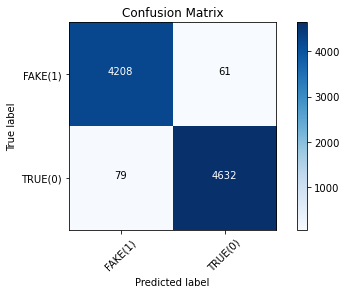

In [40]:
TFIDF_LRPipeline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression())])

model = TFIDF_LRPipeline.fit(x_train, y_train)
yPredict = model.predict(x_test)


# Evaluation Metrics
cm = confusion_matrix (y_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(y_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.2.2. SVM

Accuracy: 99.33%
Precision: 0.9936664320900774
Recall: 0.994268732753131
Confusion Matrix 
 [[4236   33]
 [  27 4684]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4269
           1       0.99      0.99      0.99      4711

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


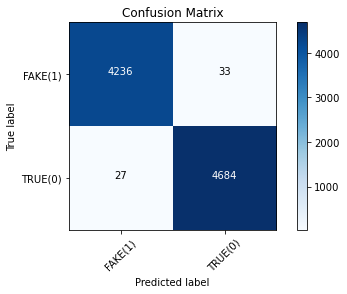

In [41]:
from sklearn.svm import SVC, LinearSVC

TFIDF_SVCPipeline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LinearSVC())])

model = TFIDF_SVCPipeline.fit(x_train, y_train)
yPredict = model.predict(x_test)

cm = confusion_matrix (y_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(y_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.2.3 NB

Accuracy: 93.26%
Precision: 0.9351543942992874
Recall: 0.9420505200594353
Confusion Matrix 
 [[3937  332]
 [ 273 4438]]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4269
           1       0.93      0.94      0.94      4711

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980

Confusion matrix, without normalization


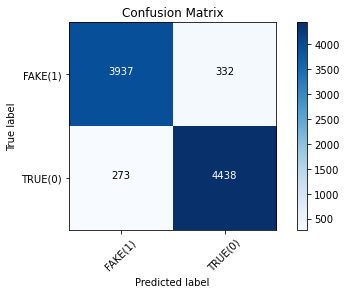

In [42]:
from sklearn.naive_bayes import MultinomialNB

TFIDF_NBPipeline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB())])

model = TFIDF_NBPipeline.fit(x_train, y_train)
yPredict = model.predict(x_test)

cm = confusion_matrix (y_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))

print ("Confusion Matrix \n", cm)
print(classification_report(y_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 6.3 Ngrams

### 6.3.1 Logistic Regression

Accuracy: 98.53%
Precision: 0.9816065192083818
Recall: 0.9832307365739757
Confusion Matrix 
 [[4216   53]
 [  79 4632]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4269
           1       0.99      0.98      0.99      4711

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


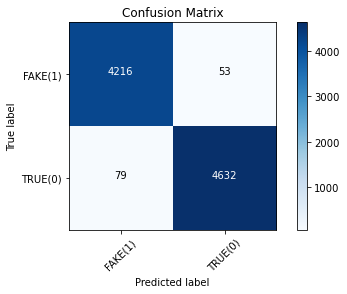

In [43]:
NGRAM_LRPipeline = Pipeline([('ngramvect', vect),
                 ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

model = NGRAM_LRPipeline.fit(x_train, y_train)

yPredict = model.predict(x_test)

cm = confusion_matrix (y_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(y_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.3.2 SVM

Accuracy: 98.9%
Precision: 0.982415548357242
Recall: 0.9838675440458501
Confusion Matrix 
 [[4246   23]
 [  76 4635]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4269
           1       1.00      0.98      0.99      4711

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


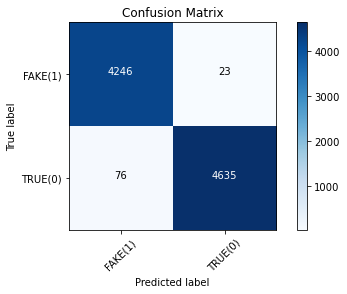

In [44]:
NGRAM_SVMPipeline = Pipeline([('vect', CountVectorizer(ngram_range=(2,3))),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LinearSVC())])

model = NGRAM_SVMPipeline.fit(x_train, y_train)
yPredict = model.predict(x_test)

cm = confusion_matrix (y_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))

print ("Confusion Matrix \n", cm)
print(classification_report(y_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.3.3 NB

Accuracy: 97.78%
Precision: 0.9676011029411765
Recall: 0.9700700488219062
Confusion Matrix 
 [[4211   58]
 [ 141 4570]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4269
           1       0.99      0.97      0.98      4711

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

Confusion matrix, without normalization


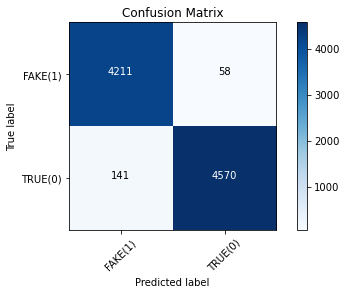

In [45]:
NGRAM_NBPipeline = Pipeline([('vect', CountVectorizer(ngram_range=(2,3) )),
                 ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

model = NGRAM_NBPipeline.fit(x_train,y_train)
yPredict = model.predict(x_test)


cm = confusion_matrix (y_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))

print ("Confusion Matrix \n", cm)
print(classification_report(y_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 6.4 POS Tags

### 6.4.1 Logistic Regression

Accuracy: 99.32%
Precision: 0.987714418173389
Recall: 0.9887497346635534
Confusion Matrix 
 [[4261    8]
 [  53 4658]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4269
           1       1.00      0.99      0.99      4711

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


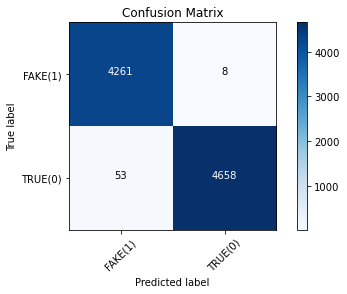

In [89]:
POS_LRPipeline = Pipeline([('vect', CountVectorizer()),
                 ('clf', LogisticRegression(max_iter=3000))])

model = POS_LRPipeline.fit(x_trainPOS,y_train)
yPredict = model.predict(x_test)

cm = confusion_matrix (y_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))

print ("Confusion Matrix \n", cm)
print(classification_report(y_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.4.2 SVM

Accuracy: 99.33%
Precision: 0.9877172653534183
Recall: 0.9887497346635534
Confusion Matrix 
 [[4262    7]
 [  53 4658]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4269
           1       1.00      0.99      0.99      4711

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


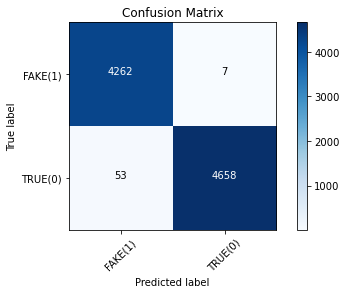

In [92]:
POS_SVMPipeline = Pipeline([('vect', CountVectorizer()),
                 ('clf', LinearSVC(max_iter = 60000 ))])

model = POS_SVMPipeline.fit(x_trainPOS,y_train)
yPredict = model.predict(x_test)

cm = confusion_matrix (y_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))

print ("Confusion Matrix \n", cm)
print(classification_report(y_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.4.3 NB

Accuracy: 94.99%
Precision: 0.9456242707117853
Recall: 0.9505412863510931
Confusion Matrix 
 [[4052  217]
 [ 233 4478]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4269
           1       0.95      0.95      0.95      4711

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

Confusion matrix, without normalization


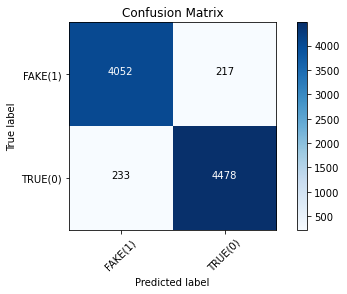

In [49]:
POS_NBPipeline = Pipeline([('vect', CountVectorizer()),
                 ('clf', MultinomialNB())])

model = POS_NBPipeline.fit(x_trainPOS,y_train)
yPredict = model.predict(x_test)

cm = confusion_matrix (y_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))

print ("Confusion Matrix \n", cm)
print(classification_report(y_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 7. Model Validation

In [50]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

folds = KFold(n_splits= 10)

In [85]:
def cv_score(model,x,y,):
    scores = cross_val_score(model,x,y, cv = folds, scoring = 'accuracy') # cv (kfolds) = 10
    print ("Mean score : {0:.3f}".format (np.mean(scores)))

In [93]:
%%time
print ("Cross validation with kfold = 10")
print ("TFIDF")
cv_score(TFIDF_LRPipeline,x_train,y_train)
cv_score(TFIDF_SVCPipeline,x_train,y_train)
cv_score(TFIDF_NBPipeline,x_train,y_train)
print("\nNgram")
cv_score(NGRAM_LRPipeline,x_train,y_train)
cv_score(NGRAM_SVMPipeline,x_train,y_train)
cv_score(NGRAM_NBPipeline,x_train,y_train)
print("\nPOS Tag")
cv_score(POS_LRPipeline,x_train,y_train)
cv_score(POS_SVMPipeline,x_train,y_train)
cv_score(POS_NBPipeline,x_train,y_train)

Cross validation with kfold = 10
TFIDF
Mean score : 0.987
Mean score : 0.994
Mean score : 0.935

Ngram
Mean score : 0.983
Mean score : 0.989
Mean score : 0.976

POS Tag
Mean score : 0.996
Mean score : 0.996
Mean score : 0.951
Wall time: 49min 19s


### 8.1 FNN Dataset

In [53]:
FNN_TestFeatures = FNN_df['cleaned']
FNN_TestLabels =FNN_df['label']

### 8.1.1 Logistic Regression

Accuracy: 53.85%
Precision: 0.8888888888888888
Recall: 0.989010989010989
Confusion Matrix 
 [[ 8 83]
 [ 1 90]]
              precision    recall  f1-score   support

           0       0.89      0.09      0.16        91
           1       0.52      0.99      0.68        91

    accuracy                           0.54       182
   macro avg       0.70      0.54      0.42       182
weighted avg       0.70      0.54      0.42       182

Confusion matrix, without normalization


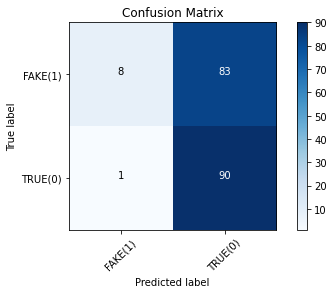

In [54]:
model = TFIDF_LRPipeline
pred = model.predict(FNN_TestFeatures)

# Evaluation Metrics
cm = confusion_matrix (FNN_TestLabels, pred)
print("Accuracy: {}%".format(round(metrics.accuracy_score(FNN_TestLabels, pred)*100,2)))
print("Precision:", metrics.precision_score(FNN_TestLabels, pred, pos_label=0))
print("Recall:", metrics.recall_score(FNN_TestLabels, pred))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(FNN_TestLabels, pred))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.1.2 SVM

Accuracy: 53.85%
Precision: 0.8888888888888888
Recall: 0.989010989010989
Confusion Matrix 
 [[ 8 83]
 [ 1 90]]
              precision    recall  f1-score   support

           0       0.89      0.09      0.16        91
           1       0.52      0.99      0.68        91

    accuracy                           0.54       182
   macro avg       0.70      0.54      0.42       182
weighted avg       0.70      0.54      0.42       182

Confusion matrix, without normalization


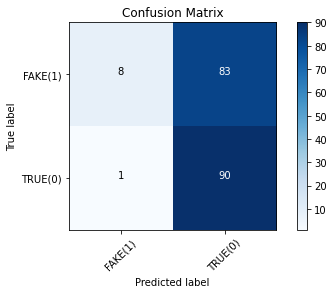

In [55]:
model = TFIDF_SVCPipeline
yPredict = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
print("Accuracy: {}%".format(round(metrics.accuracy_score(FNN_TestLabels, pred)*100,2)))
print("Precision:", metrics.precision_score(FNN_TestLabels, pred, pos_label=0))
print("Recall:", metrics.recall_score(FNN_TestLabels, pred))
print("F1 Score:", metrics.f1_score(y_test,yPredict))

print ("Confusion Matrix \n", cm)
print(classification_report(FNN_TestLabels, pred))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.1.3 NB

Accuracy: 53.3%
Precision: 0.6875
Recall: 0.945054945054945
Confusion Matrix 
 [[11 80]
 [ 5 86]]
              precision    recall  f1-score   support

           0       0.69      0.12      0.21        91
           1       0.52      0.95      0.67        91

    accuracy                           0.53       182
   macro avg       0.60      0.53      0.44       182
weighted avg       0.60      0.53      0.44       182

Confusion matrix, without normalization


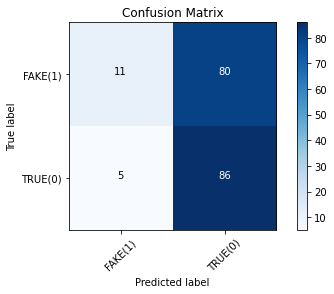

In [56]:
model = TFIDF_NBPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
print("Accuracy: {}%".format(round(metrics.accuracy_score(FNN_TestLabels, pred)*100,2)))
print("Precision:", metrics.precision_score(FNN_TestLabels, pred, pos_label=0))
print("Recall:", metrics.recall_score(FNN_TestLabels, pred))
print("F1 Score:", metrics.f1_score(y_test,yPredict))

print ("Confusion Matrix \n", cm)
print(classification_report(FNN_TestLabels, pred))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.2 Ngrams

### 8.2.1 Logistic Regression

Accuracy: 57.14%
Precision: 0.8823529411764706
Recall: 0.978021978021978
Confusion Matrix 
 [[15 76]
 [ 2 89]]
              precision    recall  f1-score   support

           0       0.88      0.16      0.28        91
           1       0.54      0.98      0.70        91

    accuracy                           0.57       182
   macro avg       0.71      0.57      0.49       182
weighted avg       0.71      0.57      0.49       182

Confusion matrix, without normalization


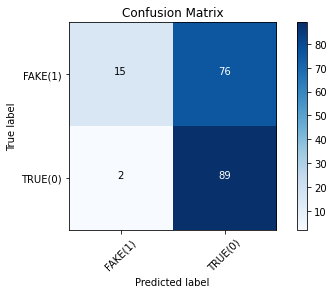

In [57]:
model = NGRAM_LRPipeline

pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
print("Accuracy: {}%".format(round(metrics.accuracy_score(FNN_TestLabels, pred)*100,2)))
print("Precision:", metrics.precision_score(FNN_TestLabels, pred, pos_label=0))
print("Recall:", metrics.recall_score(FNN_TestLabels, pred))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(FNN_TestLabels, pred))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.2.2 SVM

Accuracy: 57.14%
Precision: 0.9333333333333333
Recall: 0.989010989010989
Confusion Matrix 
 [[14 77]
 [ 1 90]]
              precision    recall  f1-score   support

           0       0.93      0.15      0.26        91
           1       0.54      0.99      0.70        91

    accuracy                           0.57       182
   macro avg       0.74      0.57      0.48       182
weighted avg       0.74      0.57      0.48       182

Confusion matrix, without normalization


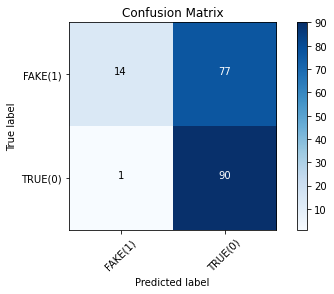

In [58]:
model = NGRAM_SVMPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
print("Accuracy: {}%".format(round(metrics.accuracy_score(FNN_TestLabels, pred)*100,2)))
print("Precision:", metrics.precision_score(FNN_TestLabels, pred, pos_label=0))
print("Recall:", metrics.recall_score(FNN_TestLabels, pred))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(FNN_TestLabels, pred))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.2.3 NB

Accuracy: 54.95%
Precision: 0.7368421052631579
Recall: 0.945054945054945
Confusion Matrix 
 [[14 77]
 [ 5 86]]
              precision    recall  f1-score   support

           0       0.74      0.15      0.25        91
           1       0.53      0.95      0.68        91

    accuracy                           0.55       182
   macro avg       0.63      0.55      0.47       182
weighted avg       0.63      0.55      0.47       182

Confusion matrix, without normalization


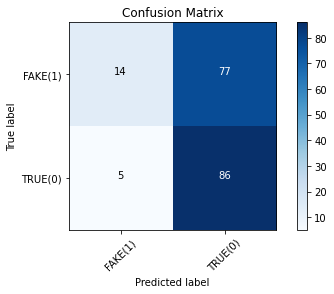

In [59]:
model = NGRAM_NBPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
print("Accuracy: {}%".format(round(metrics.accuracy_score(FNN_TestLabels, pred)*100,2)))
print("Precision:", metrics.precision_score(FNN_TestLabels, pred, pos_label=0))
print("Recall:", metrics.recall_score(FNN_TestLabels, pred))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(FNN_TestLabels, pred))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 8.3 POS Tags

### 8.3.1 Logistic Regression

Accuracy: 52.2%
Precision: 0.8333333333333334
Recall: 0.989010989010989
Confusion Matrix 
 [[ 5 86]
 [ 1 90]]
              precision    recall  f1-score   support

           0       0.83      0.05      0.10        91
           1       0.51      0.99      0.67        91

    accuracy                           0.52       182
   macro avg       0.67      0.52      0.39       182
weighted avg       0.67      0.52      0.39       182

Confusion matrix, without normalization


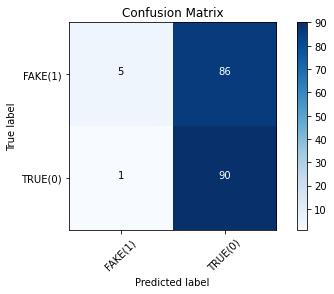

In [60]:
model = POS_LRPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
print("Accuracy: {}%".format(round(metrics.accuracy_score(FNN_TestLabels, pred)*100,2)))
print("Precision:", metrics.precision_score(FNN_TestLabels, pred, pos_label=0))
print("Recall:", metrics.recall_score(FNN_TestLabels, pred))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(FNN_TestLabels, pred))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.3.2 SVM

Accuracy: 52.75%
Precision: 1.0
Recall: 1.0
Confusion Matrix 
 [[ 5 86]
 [ 0 91]]
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        91
           1       0.51      1.00      0.68        91

    accuracy                           0.53       182
   macro avg       0.76      0.53      0.39       182
weighted avg       0.76      0.53      0.39       182

Confusion matrix, without normalization


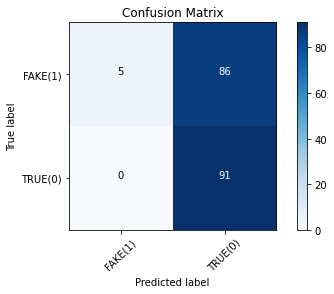

In [61]:
model = POS_SVMPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
print("Accuracy: {}%".format(round(metrics.accuracy_score(FNN_TestLabels, pred)*100,2)))
print("Precision:", metrics.precision_score(FNN_TestLabels, pred, pos_label=0))
print("Recall:", metrics.recall_score(FNN_TestLabels, pred))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(FNN_TestLabels, pred))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.3.3 NB

Accuracy: 53.3%
Precision: 0.6875
Recall: 0.945054945054945
Confusion Matrix 
 [[11 80]
 [ 5 86]]
              precision    recall  f1-score   support

           0       0.69      0.12      0.21        91
           1       0.52      0.95      0.67        91

    accuracy                           0.53       182
   macro avg       0.60      0.53      0.44       182
weighted avg       0.60      0.53      0.44       182

Confusion matrix, without normalization


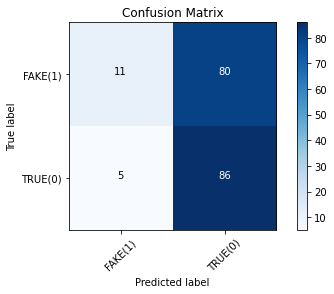

In [62]:
model = POS_NBPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
print("Accuracy: {}%".format(round(metrics.accuracy_score(FNN_TestLabels, pred)*100,2)))
print("Precision:", metrics.precision_score(FNN_TestLabels, pred, pos_label=0))
print("Recall:", metrics.recall_score(FNN_TestLabels, pred))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(FNN_TestLabels, pred))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 9. Combining Features

In [63]:
x = ISOT_df.tokenized
y = ISOT_df.label

x2_train,x2_test,y2_train,y2_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(35918,) (8980,) (35918,) (8980,)


## 9.1 Lemm + CountWord

### 9.1.1 Logitisc Regression

Accuracy: 99.64%
Precision: 0.9964846496367471
Recall: 0.9968159626406283
Confusion Matrix 
 [[4252   17]
 [  15 4696]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4269
           1       1.00      1.00      1.00      4711

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Confusion matrix, without normalization


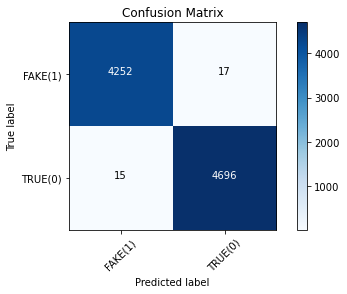

In [64]:
LRmodel = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(max_iter = 1000))
])
                          
model = LRmodel.fit(x2_train, y2_train)
yPredict = model.predict(x2_test)

# Evaluation Metrics
cm = confusion_matrix (y2_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y2_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y2_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y2_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))


print ("Confusion Matrix \n", cm)
print(classification_report(y2_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

Accuracy: 99.65%
Precision: 0.9960205992509363
Recall: 0.9963914243260454
Confusion Matrix 
 [[4255   14]
 [  17 4694]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4269
           1       1.00      1.00      1.00      4711

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Confusion matrix, without normalization


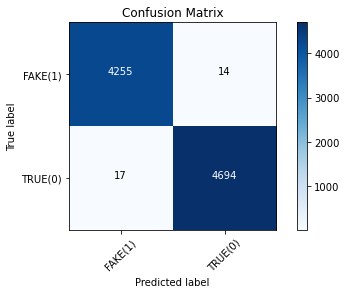

In [94]:
SVMModel = Pipeline([('vect', CountVectorizer()),
                 ('clf', LinearSVC(max_iter = 60000))])
               
model = SVMModel.fit(x2_train, y2_train)
yPredict = model.predict(x2_test)

cm = confusion_matrix (y2_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y2_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y2_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y2_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))

print ("Confusion Matrix \n", cm)
print(classification_report(y_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

Accuracy: 95.31%
Precision: 0.9461966604823747
Recall: 0.9507535555083846
Confusion Matrix 
 [[4080  189]
 [ 232 4479]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      4269
           1       0.96      0.95      0.96      4711

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

Confusion matrix, without normalization


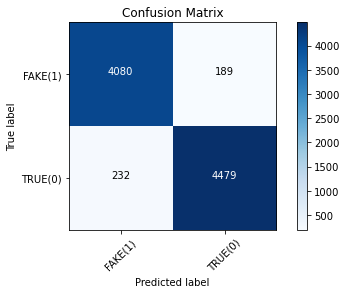

In [66]:
NBModel = Pipeline([('vect', CountVectorizer()),
                 ('clf', MultinomialNB())])

model = NBModel.fit(x2_train, y2_train)
yPredict = model.predict(x2_test)

cm = confusion_matrix (y2_test, yPredict)
print("Accuracy: {}%".format(round(metrics.accuracy_score(y2_test, yPredict)*100,2)))
print("Precision:", metrics.precision_score(y2_test, yPredict, pos_label=0))
print("Recall:", metrics.recall_score(y2_test, yPredict))
print("F1 Score:", metrics.f1_score(y_test,yPredict))

print ("Confusion Matrix \n", cm)
print(classification_report(y2_test, yPredict))
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])